In [1]:
# Import custom class and functions
from inputproducer import InputProducer
#from tracker import TrackerVanilla
from vgg16 import Vgg16
from selcnn import SelCNN
#from sgnet import GNet, SNet
from utils import img_with_bbox, IOU_eval

import numpy as np 
import tensorflow as tf

import os

import skimage.io
show = skimage.io.imshow
%matplotlib inline



tf.app.flags.DEFINE_integer('iter_step_sel', 200,
                          """Number of steps for trainning"""
                          """selCNN networks.""")
tf.app.flags.DEFINE_integer('iter_step_sg', 50,
                          """Number of steps for trainning"""
                          """SGnet works""")
tf.app.flags.DEFINE_integer('num_sel', 384,
                          """Number of feature maps selected.""")
tf.app.flags.DEFINE_integer('iter_max', 200,
							"""Max iter times through imgs""")

FLAGS = tf.app.flags.FLAGS

## Define varies path
DATA_ROOT = 'data/Dog1'
IMG_PATH = os.path.join(DATA_ROOT, 'img')
GT_PATH = os.path.join(DATA_ROOT, 'groundtruth_rect.txt')
VGG_WEIGHTS_PATH = 'vgg16_weights.npz'

In [2]:
inputProducer = InputProducer(IMG_PATH, GT_PATH)
img, gt, t  = next(inputProducer.gen_img)
roi,_,_,_ = inputProducer.extract_roi_deprecated(img, gt)

sess = tf.Session()

vgg = Vgg16(VGG_WEIGHTS_PATH, sess)

lselCNN = SelCNN('sel_local', vgg.conv4_3)
gselCNN = SelCNN('sel_global', vgg.conv5_3)

lgt_M = inputProducer.gen_mask(lselCNN.pre_M_size)
ggt_M = inputProducer.gen_mask(gselCNN.pre_M_size)



/home/xlws/repos/FCNT_TF/inputproducer.py:244: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [self.roi_params['roi_size'], self.roi_params['roi_size']], interp='bicubic')


0.0013186425201 max of mask
(224, 224, 3)
250 max convas
0.0013186425201 max of mask
(224, 224, 3)
228 max convas


/home/xlws/repos/FCNT_TF/inputproducer.py:85: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi = convas[cy-half:cy+half, cx-half:cx+half, :]


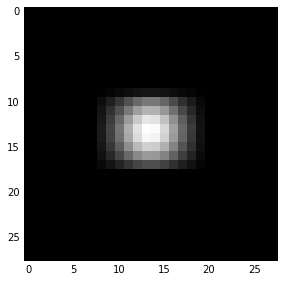

In [3]:
show(lgt_M)

In [4]:
lgt_M = lgt_M.astype(np.float32)[np.newaxis,:,:,np.newaxis]
ggt_M = ggt_M.astype(np.float32)[np.newaxis,:,:,np.newaxis]


In [5]:

import tensorflow as tf
import numpy as np 

from utils import variable_on_cpu, variable_with_weight_decay


class SGNet:

    # Define class level optimizer
    #lr = 1e-6
    #optimizer = tf.train.GradientDescentOptimizer(lr)

    def __init__(self, scope, vgg_conv_shape):
        """
        Base calss for SGNet, defines the network structure
        """
        self.scope = scope
        self.params = {
        'num_fms': 200, # number of selected featrue maps, inputs of the network
        'wd': 0.5, # L2 regulization coefficient
        }
        self.variables = []
        with tf.variable_scope(scope) as scope:
            self.pre_M = self._build_graph(vgg_conv_shape)

    def _build_graph(self, vgg_conv_shape):
        """
        Define Structure. 
        The first additional convolutional
        layer has convolutional kernels of size 9×9 and outputs
        36 feature maps as the input to the next layer. The second
        additional convolutional layer has kernels of size 5 × 5
        and outputs the foreground heat map of the input image.
        ReLU is chosen as the nonlinearity for these two layers.

        Args:
            vgg_conv_shape: 
        Returns:
            conv2: 
        """
        self.variables = []
        self.kernel_weights = []
        out_num = vgg_conv_shape[-1]
        self.input_maps = tf.placeholder(tf.float32, shape=vgg_conv_shape,
            name='selected_maps')
        #assert vgg_conv_shape[-1] == self.params['num_fms']
        
        with tf.name_scope('conv1') as scope:
            kernel = tf.Variable(tf.truncated_normal([9,9,out_num,36], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(self.input_maps, kernel, [1, 1, 1, 1], padding='SAME')
            biases = tf.Variable(tf.constant(0.0, shape=[36], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv1 = tf.nn.relu(out, name=scope)
            self.variables += [kernel, biases]
            self.kernel_weights += [kernel]
            print(conv1.get_shape().as_list(), 'conv1 shape')


        with tf.name_scope('conv2') as scope:
            kernel = tf.Variable(tf.truncated_normal([5,5,36,1], dtype=tf.float32,
                                                     stddev=1e-1), name='weights')
            conv = tf.nn.conv2d(conv1, kernel , [1, 1, 1, 1], padding='SAME')
            print(conv.get_shape().as_list(), 'conv shape')
            biases = tf.Variable(tf.constant(0.0, shape=[1], dtype=tf.float32),
                                 trainable=True, name='biases')
            out = tf.nn.bias_add(conv, biases)
            conv2 = tf.nn.relu(out, name=scope)
            self.variables += [kernel, biases]
            self.kernel_weights += [kernel]

        print('Shape of the out put heat map for %s is %s'%(self.scope, conv2.get_shape().as_list()))
        return conv2

    def loss(self, gt_M):
        """Returns Losses for the current network.

        Args:
            gt_M: Tensor, ground truth heat map.

        Returns:
            Loss: 
        """

        # Assertion
        with tf.name_scope(self.scope) as scope:
            beta = tf.constant(self.params['wd'], name='beta')
            loss_rms = tf.reduce_mean(tf.square(tf.sub(gt_M, self.pre_M))) 
            loss_wd = [tf.reduce_mean(tf.square(w)) for w in self.kernel_weights]
            loss_wd = beta * tf.add_n(loss_wd)
            total_loss = loss_rms + loss_wd
        return total_loss

    @classmethod
    def eadge_RP():
        """
        This method propose a series of ROI along eadges
        of a given frame. This should be called when particle 
        confidence below a critical value, which possibly accounts
        for object re-appearance.
        """
        pass



class GNet(SGNet):
    def __init__(self, scope, vgg_conv_shape):
        """
        Fixed params once trained in the first frame
        """
        super(GNet, self).__init__(scope, vgg_conv_shape)






class SNet(SGNet):
    def __init__(self, scope, vgg_conv_shape):
        """
        Initialized in the first frame
        """
        super(SNet, self).__init__(scope, vgg_conv_shape)

    def adaptive_finetune(self, sess, updated_gt_M):
        """Finetune SNet with updated_gt_M."""

        pass

    def descrimtive_finetune(self, sess, init_gt_M, cur_):
        pass



In [6]:
s_sel_maps = np.random.random((1, 28,28,FLAGS.num_sel))
g_sel_maps = np.random.random((1, 14,14,FLAGS.num_sel))

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [7]:
# Instantiate G and S networks by sending selected saliency maps.
gnet = GNet('GNet', g_sel_maps.shape)
snet = SNet('SNet', s_sel_maps.shape)


[1, 14, 14, 36] conv1 shape
[1, 14, 14, 1] conv shape
Shape of the out put heat map for GNet is [1, 14, 14, 1]
[1, 28, 28, 36] conv1 shape
[1, 28, 28, 1] conv shape
Shape of the out put heat map for SNet is [1, 28, 28, 1]


In [ ]:
[v.get_shape().as_list() for v in gnet.kernel_weights]

In [8]:

sess.run(tf.initialize_all_variables())
#sess.run(tf.report_uninitialized_variables())

In [ ]:
#uninit_SGNet_vars = gnet.variables + snet.variables
#init_SGNet_vars_op = tf.initialize_variables(uninit_SGNet_vars)
#sess.run(init_SGNet_vars_op)

In [21]:
gnet.pre_M.get_shape()

TensorShape([Dimension(1), Dimension(14), Dimension(14), Dimension(1)])

In [20]:
tf.sub(snet.pre_M, lgt_M)

<tf.Tensor 'Sub:0' shape=(1, 28, 28, 1) dtype=float32>

In [11]:
sloss = snet.loss(lgt_M)

In [12]:
gloss = gnet.loss(ggt_M)

In [13]:
total_losses = sloss + gloss

In [14]:
sgNet_vars = gnet.variables + snet.variables

In [15]:
lr = 1e-8
optimizer = tf.train.GradientDescentOptimizer(lr)

train_op = optimizer.minimize(total_losses, var_list= sgNet_vars)


In [16]:

feed_dict = {gnet.input_maps: g_sel_maps, snet.input_maps: s_sel_maps}
loss = sess.run(total_losses, feed_dict = feed_dict)

In [17]:
loss

211.17242

In [ ]:
snet.input_maps

In [ ]:
gnet.input_maps

In [ ]:
"""
Train sgnet by minimize the loss
Loss = Lg + Ls
where Li = |pre_Mi - gt_M|**2 + Weights_decay_term_i

"""

lr = 1e-8
optimizer = tf.train.GradientDescentOptimizer(lr)

train_op = optimizer.minimize(total_losses, var_list= sgNet_vars)

# initializa SGNet.variables

feed_dic = {gnet.input_maps: g_sel_maps, snet.input_maps: s_sel_maps}
loss = sess.run(total_losses, feed_dic = feed_dic)

In [ ]:
gt_M = gt_M.astype(np.float32)